In [1]:
from datetime import date, timedelta, datetime
from pyspark.sql.functions import collect_list, substring
from pyspark.sql import Row
from matplotlib import pyplot as plt
from functools import partial
from collections import Counter
import ujson as json

%matplotlib inline

In [2]:
def int2date(n):
    """
    This function converts a number of days since Jan 1st 1970 <n> to a date.
    """
    try:
        return date(1970,1,1)+timedelta(days=n)
    except:
        return date(1970,1,1)

def date2int(d):
    """
    This function converts a date <d> to number of days since Jan 1st 1970.
    """
    try:
        return (d-date(1970,1,1)).days
    except:
        return -1

def str2date(s, f="%Y%m%d"):
    """
    This function converts a string <s> in the format <f> to a date.
    """
    try:
        return datetime.strptime(s, f).date()
    except:
        return ""

TODAY = date.today()                                    # today (date)
TODAY_INT = date2int(TODAY)                             # today (days since Jan 1st, 1970)
PCD_CUTOUT_START_DATE = date(2010, 1, 1)                # profiles created before this date are removed (date)
PCD_CUTOUT_START_INT = date2int(PCD_CUTOUT_START_DATE)  # profiles created before this date are removed (days since Jan 1st, 1970)
T0 = 30                                                 # days of latency
T1 = 90                                                 # days to come back
T2 = 180                                                # maximum date to go back in the past for tsla

# Functions with data

In [3]:
def read_main_summary():
    """
    This function imports the main_summary dataset from S3, selects the variables of interest,
    applies several filters, and returns the filtered dataset.
    """
    
    # connect to the main_summary dataset
    allPingsDF = sqlContext.read.load("s3://telemetry-parquet/main_summary/v3", "parquet", mergeSchema=True)
    
    # perform variable selection with column renaming
    allPingsDFSelect = allPingsDF.select(
               allPingsDF.client_id.alias("cid"),
               allPingsDF.subsession_start_date.alias("ssd"),
               allPingsDF.sample_id.alias("sid"),
               allPingsDF.normalized_channel.alias("channel"),
               allPingsDF.app_name.alias("appname"),
               allPingsDF.subsession_length.alias("ssl"),
               allPingsDF.profile_creation_date.alias("pcd")
    )

    # - 1% sample (sample_id is 42)
    # - channel is release
    # - application is Firefox
    # - subsession length is positive and less than 24h
    # - profile creation date is after Jan 1st, 2010 and before TODAY
    filteredPingsDF = allPingsDFSelect.filter(allPingsDFSelect.sid == "42")\
                                      .filter(allPingsDFSelect.channel == "release")\
                                      .filter(allPingsDFSelect.appname == "Firefox")\
                                      .filter(allPingsDFSelect.ssl >= 0)\
                                      .filter(allPingsDFSelect.ssl <= 86400)\
                                      .filter(allPingsDFSelect.pcd >= PCD_CUTOUT_START_INT)\
                                      .filter(allPingsDFSelect.pcd <= TODAY_INT)\
                                      .select(["cid",
                                               substring("ssd", 0, 10).alias("ssd")
                                              ])\
                                      .cache()
    
    # return filtered dataframe
    return filteredPingsDF

def get_active_on_date(DF_str, day):
    """
    This function creates and returns a table that is aggregated by client_id (cid) and subsession_start_date (ssd).
    Only client_ids that were active on given date are kept.
    For each tuple (cid, sd), the number of subsessions per day is aggregated.
    NOTE: This could be changed. For example, we may not need to know that a user was active multiple times per day.
    
    @params:
        DF_str: [string] name of the dataframe returned by aggregate_by_client_date(...)
        day: [date] date for analysis
    """
    
    query = """
    SELECT cid,
           ssd,
           count(*) as num_ssd
    FROM {table}
    WHERE cid IN
    (
        SELECT distinct cid
        FROM {table}
        WHERE ssd = '{day}'
    )
    GROUP BY cid, ssd
    """.format(table=DF_str,
               day=day.isoformat())
    
    active = spark.sql(query).cache()
    
    return active

def make_longitudinal(aggregate_df):
    """
    This function creates and returns a longitudinal dataframe from the aggregate dataframe grouped by client_id (cid).
    Each Row from this dataframe contains the sequential information (lists) for:
        - subsession_start_date (ssd),
        - num_ssd (num_ssd)
    for each cid.
    
    @params:
        agg_subset: [dataframe] dataframe returned by get_active_on_date(...)
    """

    longitudinal = aggregate_df.groupBy("cid")\
                               .agg({"ssd": "collect_list",
                                     "num_ssd": "collect_list"})\
                               .withColumnRenamed("collect_list(ssd)","ssd")\
                               .withColumnRenamed("collect_list(num_ssd)", "num_ssd")
    
    return longitudinal

def mapping(row, day):
    """
    Applied to an RDD, this mapping function returns a tuple of 5 elements:
        - cid
        - ssd (sorted ascending through time)
        - num_ssd (sorted according to ssd)
        - tsla (time since last activity in days)
        - tuna (time until next activity in days)
    
    @params:
        row: [Row] a row from a longitudinal RDD that includes:
            - cid: client_id
            - ssd: subsession_start_date
        day: [date] date of analysis
    
    @logic:
        - sort the row based on ssd (ascending).
        - if there was activity prior to D0, get tsla
        - if there was activity after D0, get tuna
            - if not, those are set to -1
            - in case of badly formatted ssd, return -2
    """
    
    def sort_row(row):
        # sort ssd by ascending ssd
        zipped = sorted(zip(row.ssd, row.num_ssd), reverse=False)
        ssd, num_ssd = zip(*zipped)
        
        # return reformatted Row
        return Row(cid=row.cid,
                   ssd=list(ssd),
                   num_ssd=list(num_ssd)
                  )
    
    tsla = -1                        # time since last activity (days)
    tuna = -1                        # time until next activity (days)
    
    sorted_row = sort_row(row)      # sorted row
    
    # find index of D0
    index_D0 = sorted_row.ssd.index(day.isoformat())
    indices_before_D0 = range(index_D0)
    indices_after_D0 = range(index_D0+1, len(sorted_row.ssd))
    
    # there was activity prior to D0
    if len(indices_before_D0) > 0:
        try:
            # get last entry from the row before D0
            last_activity_date = sorted_row.ssd[indices_before_D0[-1]]
            tsla = (day - datetime.strptime(last_activity_date, '%Y-%m-%d').date()).days
        except:
            # error in date format
            tsla = -2
    # maybe else check if num_ssd > 1 (active on same day), then tsla = 0?
    
    # there was activity after D0
    if len(indices_after_D0) > 0:
        try:
            # get first entry from the row after D0
            next_activity_date = sorted_row.ssd[indices_after_D0[0]]
            tuna = (datetime.strptime(next_activity_date, '%Y-%m-%d').date() - day).days
        except:
            # error in date format
            tuna = -2
    # maybe else check if num_ssd > 1 (active on same day), then tuna = 0?

    return (sorted_row.cid,              # cid
            sorted_row.ssd,              # list of ssd (ascending)
            sorted_row.num_ssd,          # list of num_ssd (based on ssd)
            tsla,                        # time since last activity (days)
            tuna,                        # time until next activity (days)
           )

def count_mapped_filter(table, f):
    """
    This function applies a filter function to an rdd.
    
    @params:
        - table [rdd] RDD to which we will apply the filter
        - f [function] lambda function to apply the filter
    """
    
    return table.filter(f).count()

# Functions with files

In [4]:
def write_col_json(fn, df_col, date_str, measure_str):
    """
    This function writes the counter from a column from a dataframe to a json file.
    
    @params:
        fn: [tring] file name of output json
        df_col: [Series] column of the dataframe to create counter
        date_str: [string] date to append to file name
        measure_str: [string] name of measure (ex: "tsla", "tuna"...) to append to file name
    """
    
    cnter = dict(Counter(df_col))
    inter = cnter.keys()
    inter = [int(float(d)) for d in inter]
    counts = cnter.values()

    json_str = '[%s]'
    row_str = '{"days":%s, "count":%s}'

    all_rows = []
    for i in range(len(inter)):
        all_rows.append(row_str%(inter[i], counts[i])) 

    all_rows_str = ",".join(all_rows)

    json_final = json_str%all_rows_str
    
    suffix = "_" + measure_str + "-" + date_str
    file_name = fn + suffix + ".json"
    
    if os.path.exists(file_name):
        print "{} exists, we will overwrite it.".format(file_name)

    with open(file_name, "w") as json_file:
        json_file.write(json_final)

def write_dict_json(fn, res_data, date_str):
    """
    This function writes the content of a dictionary to a json file.
    
    @params:
        fn: [string] file name of output json
        res_data: [dict] dictionary object with summary data
        date_str: [string] date to append to file name
    """
    
    suffix = "-" + date_str
    file_name = fn + suffix + ".json"
    
    if os.path.exists(file_name):
        print "{} exists, we will overwrite it.".format(file_name)

    # res_data is a JSON object.
    json_entry = json.dumps(res_data)

    with open(file_name, "w") as json_file:
        json_file.write("[" + json_entry.encode('utf8') + "]\n")

def make_dict_results(date_str, dau, tsla_neg_cnt, tuna_neg_cnt, tsla_tuna_neg_cnt, bad_dates_cnt,
                      tsla_30_cnt, tuna_90_cnt):
    """
    This function returns a dictionary with a summary of the results to output a json file.
    
    @params:
        keys to save as a dictionary. Self-explanatory
    """
    
    return {
        "date": date_str,
        "tsla_neg_prop": tsla_neg_cnt*1./dau,
        "tuna_neg_prop": tuna_neg_cnt*1./dau,
        "tsla_tuna_neg_prop": tsla_tuna_neg_cnt*1./dau,
        "bad_dates_prop": bad_dates_cnt*1./dau,
        "tsla_30_prop": tsla_30_cnt*1./dau,
        "tuna_90_prop": tuna_90_cnt*1./dau
    }

In [5]:
def main(start_backfill, end_backfill):
    print "***** READING DATA...",
    filteredPingsDF = read_main_summary()
    filteredPingsDF_str = "filteredPingsDF"
    sqlContext.registerDataFrameAsTable(filteredPingsDF, filteredPingsDF_str)
    print "Done!"
    
    # get date ranges
    dates = [] # --list of all end_dates in period
    print "***** FINDING ALL days BETWEEN {start} AND {end}..."\
           .format(start=start_backfill, end=end_backfill),

    # get all days between the two provided dates
    delta = end_backfill - start_backfill
    for i in range(delta.days + 1):
        day = start_backfill + timedelta(days=i)
        dates.append(day)
    print "{} DATES".format(len(dates))
    
    for i, d in enumerate(dates):
        print
        print "***** DATE {curr} of {tot}".format(curr=i+1, tot=len(dates))
        D0 = d                                                  # date of of analysis (date)
        D0_INT = date2int(D0)                                   # date of analysis (days since Jan 1st, 1970)

        D0_T0 = D0 - timedelta(days=T0)                         # date beginning of latency period (date)
        D0_T0_INT = D0_INT - T0                                 # date beginning of latency period (days since Jan 1st, 1970)

        D0_T1 = D0 + timedelta(days=T1)                         # date beginning of come back period (date)
        D0_T1_INT = D0_INT + T1                                 # date beginning of come back period (days since Jan 1st, 1970)
        print "***** WORKING ON DAY {}".format(D0.isoformat())
        
        print "\t Aggregating data...",
        activeDF = get_active_on_date(filteredPingsDF_str, D0)
        activeDF_str = "activeDF"
        sqlContext.registerDataFrameAsTable(activeDF, activeDF_str)
        print "Done!"
        
        print "\t Getting DAU...",
        dau = activeDF.select("cid").distinct().count()*100
        print "Done!"

        print "\t Making longitudinal...",
        longitudinal = make_longitudinal(activeDF)
        print "Done!"
        
        print "\t Mapping data...",
        mapping_partial = partial(mapping, day = D0)
        mapped = longitudinal.rdd.map(mapping_partial)
        print "Done!"

        print "\t Getting counts..."
        # Negative tsla <=> not active before D0
        tsla_neg_cnt = count_mapped_filter(mapped, lambda row: row[3] < 0)*100
        # Negative tuna <=> not active after D0
        tuna_neg_cnt = count_mapped_filter(mapped, lambda row: row[4] < 0)*100
        # Negative tsla and tuna <=> only active on D0
        tsla_tuna_neg_cnt = count_mapped_filter(mapped, lambda row: (row[3] < 0 and row[4] < 0))*100
        # One row has a badly formatted date at some point
        # We can disregard it (or implement some better error checking at some point)
        bad_dates_cnt = count_mapped_filter(mapped, lambda row: (row[3] == -2 or row[4] == -2))*100

        # tsla >= 30 <=> last time user was active was more than T0 (30) days before D0
        tsla_30 = mapped.filter(lambda row: row[3] >= T0)
        tsla_30_cnt = tsla_30.count()*100
        tsla = tsla_30.map(lambda row: row[3]).collect()
        plt.hist(x=tsla, bins=range(T0, T2, 1), normed=1)
        plt.show()
        write_col_json("fx_retusers", tsla, D0.isoformat(), "tsla")

        # 0 < tuna <= 90 <=> next time user was active after D0
        tuna_90 = mapped.filter(lambda row: (row[4] > 0 and row[4] <= T1))
        tuna_90_cnt = tuna_90.count()*100
        tuna = tuna_90.map(lambda row: row[4]).collect()
        plt.hist(x=tuna, bins=range(0, T1, 1), normed=1)
        plt.show()
        write_col_json("fx_retusers", tuna, D0.isoformat(), "tuna")
        
        print "\t Saving json...",
        summary = make_dict_results(D0.isoformat(), dau, tsla_neg_cnt, tuna_neg_cnt, tsla_tuna_neg_cnt, bad_dates_cnt,
                      tsla_30_cnt, tuna_90_cnt)
        write_dict_json("fx_retusers", summary, D0.strftime("%Y%m%d"))
        print "Done!"
    
    print 
    print "***** MERGING SUMMARY JSON FILES...",
    # merge summary JSON files into one
    !jq -c -s "[.[]|.[]]" fx_retusers-*.json > "fx_retusers.json"
    print "DONE!"

***** READING DATA... Done!
***** FINDING ALL days BETWEEN 2016-09-01 AND 2016-09-30... 30 DATES

***** DATE 1 of 30
***** WORKING ON DAY 2016-09-01
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


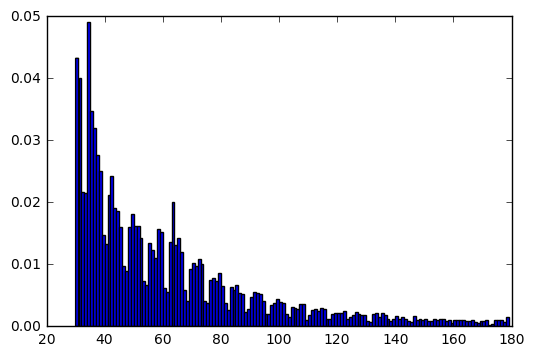

fx_retusers_tsla-2016-09-01.json exists, we will overwrite it.


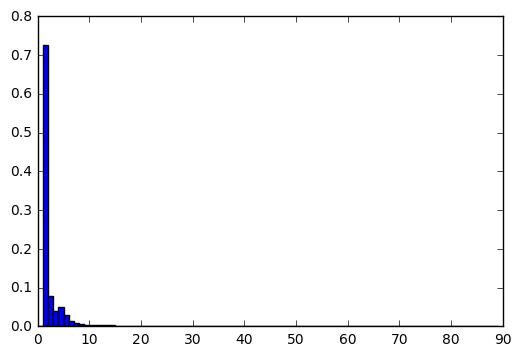

fx_retusers_tuna-2016-09-01.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-01.json exists, we will overwrite it.
Done!

***** DATE 2 of 30
***** WORKING ON DAY 2016-09-02
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


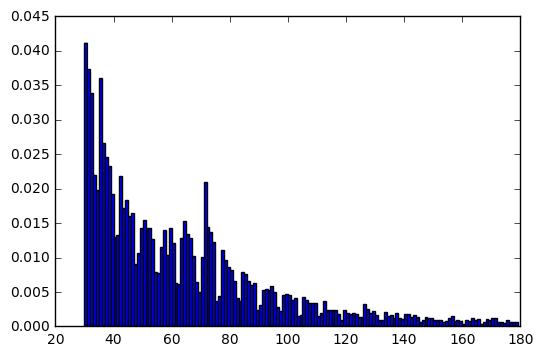

fx_retusers_tsla-2016-09-02.json exists, we will overwrite it.


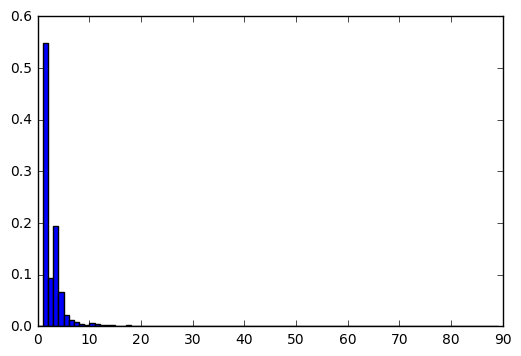

fx_retusers_tuna-2016-09-02.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-02.json exists, we will overwrite it.
Done!

***** DATE 3 of 30
***** WORKING ON DAY 2016-09-03
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


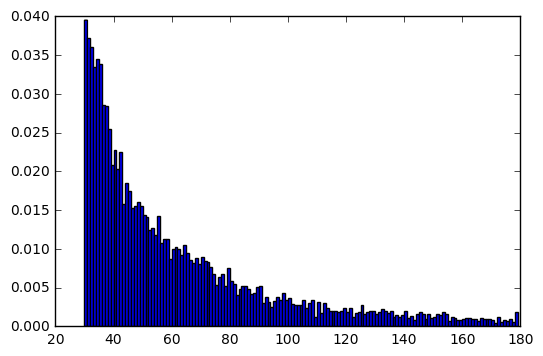

fx_retusers_tsla-2016-09-03.json exists, we will overwrite it.


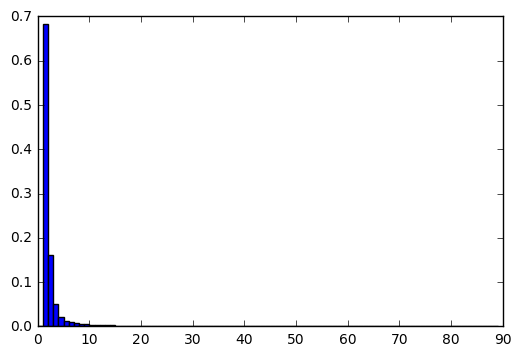

fx_retusers_tuna-2016-09-03.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-03.json exists, we will overwrite it.
Done!

***** DATE 4 of 30
***** WORKING ON DAY 2016-09-04
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


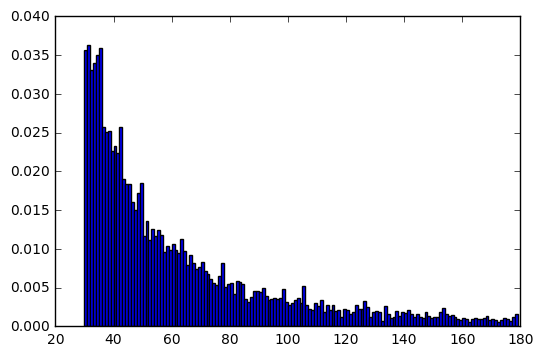

fx_retusers_tsla-2016-09-04.json exists, we will overwrite it.


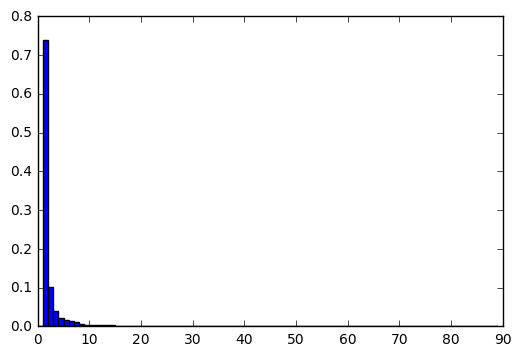

fx_retusers_tuna-2016-09-04.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-04.json exists, we will overwrite it.
Done!

***** DATE 5 of 30
***** WORKING ON DAY 2016-09-05
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


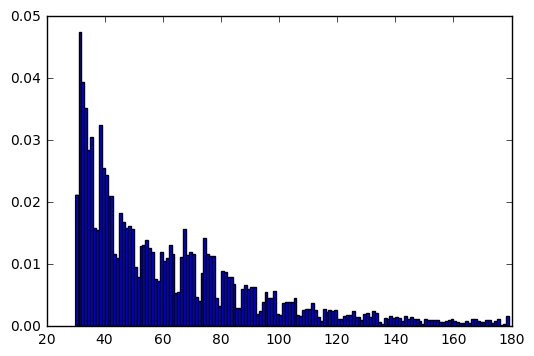

fx_retusers_tsla-2016-09-05.json exists, we will overwrite it.


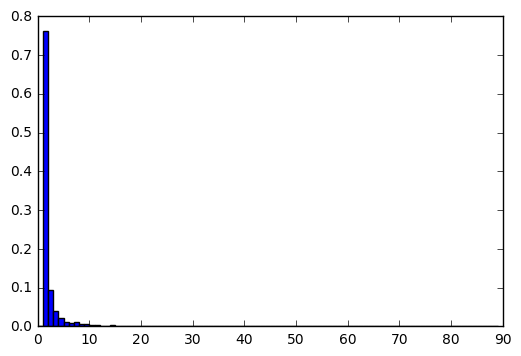

fx_retusers_tuna-2016-09-05.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-05.json exists, we will overwrite it.
Done!

***** DATE 6 of 30
***** WORKING ON DAY 2016-09-06
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


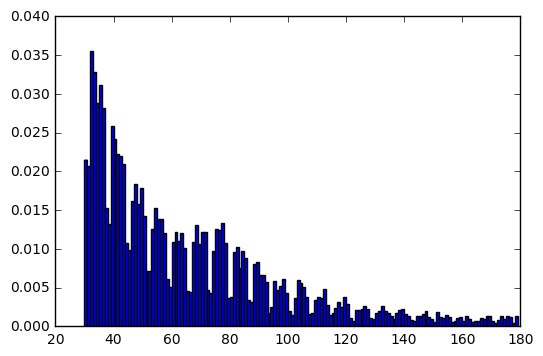

fx_retusers_tsla-2016-09-06.json exists, we will overwrite it.


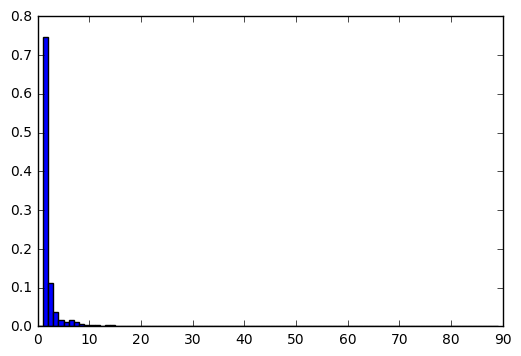

fx_retusers_tuna-2016-09-06.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-06.json exists, we will overwrite it.
Done!

***** DATE 7 of 30
***** WORKING ON DAY 2016-09-07
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


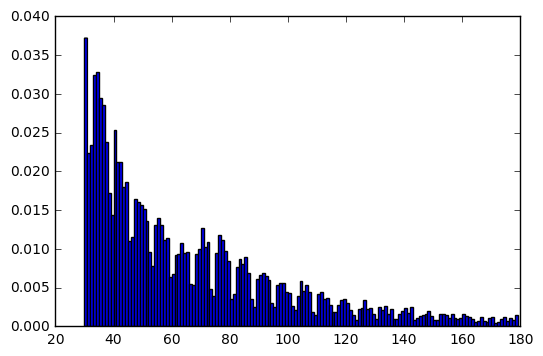

fx_retusers_tsla-2016-09-07.json exists, we will overwrite it.


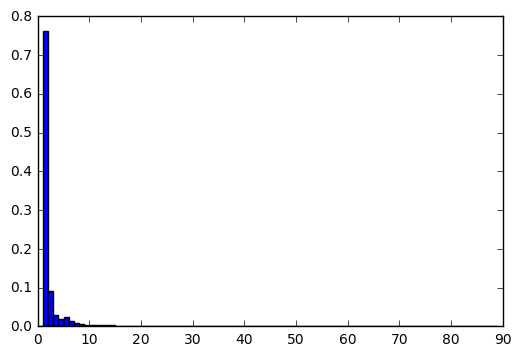

fx_retusers_tuna-2016-09-07.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-07.json exists, we will overwrite it.
Done!

***** DATE 8 of 30
***** WORKING ON DAY 2016-09-08
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


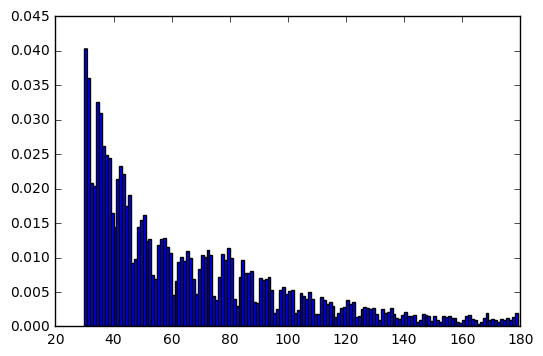

fx_retusers_tsla-2016-09-08.json exists, we will overwrite it.


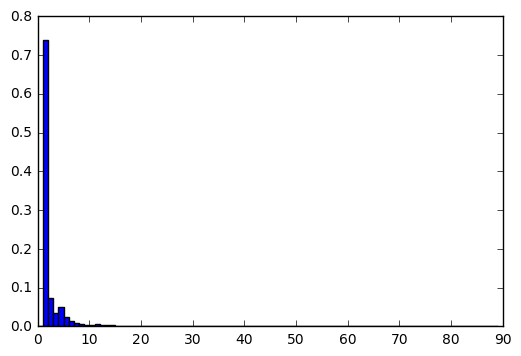

fx_retusers_tuna-2016-09-08.json exists, we will overwrite it.
	 Saving json... fx_retusers-2016-09-08.json exists, we will overwrite it.
Done!

***** DATE 9 of 30
***** WORKING ON DAY 2016-09-09
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


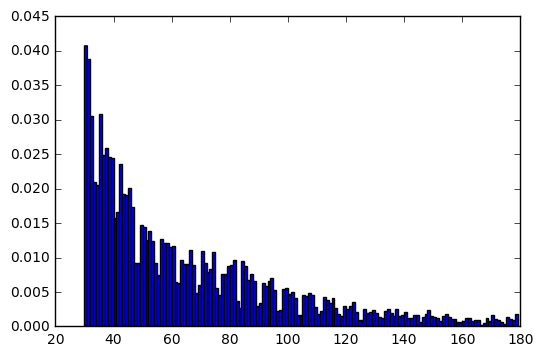

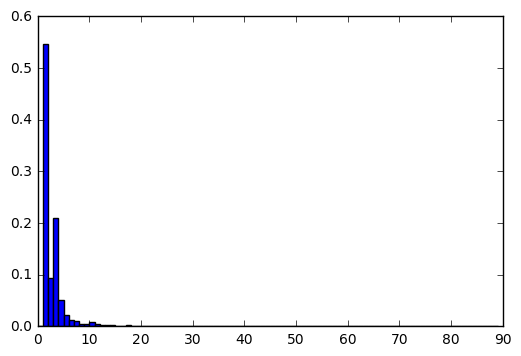

	 Saving json... Done!

***** DATE 10 of 30
***** WORKING ON DAY 2016-09-10
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


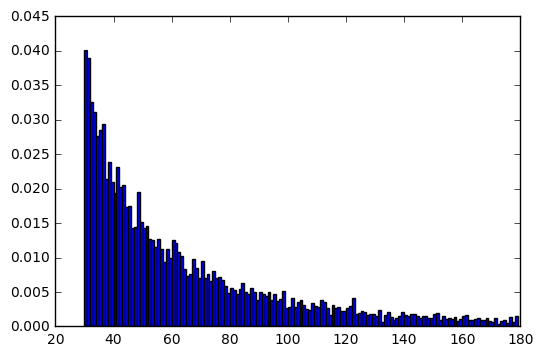

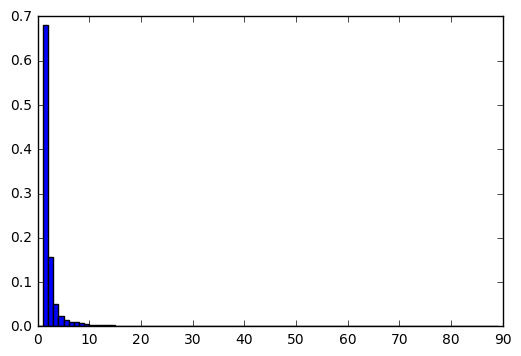

	 Saving json... Done!

***** DATE 11 of 30
***** WORKING ON DAY 2016-09-11
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


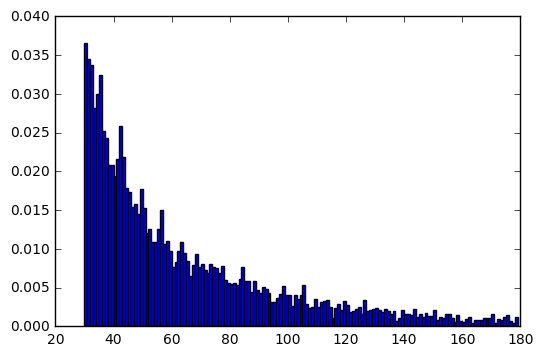

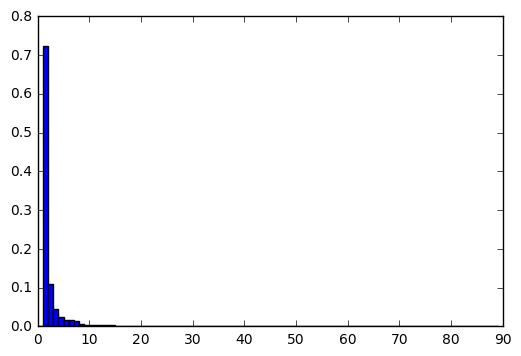

	 Saving json... Done!

***** DATE 12 of 30
***** WORKING ON DAY 2016-09-12
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


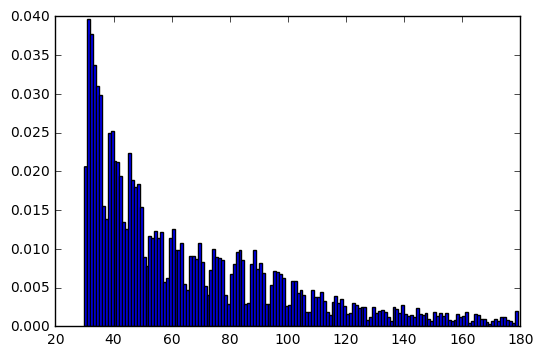

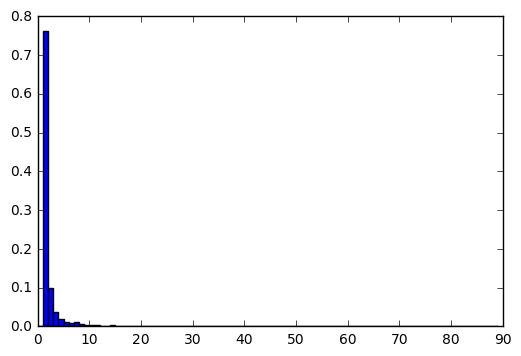

	 Saving json... Done!

***** DATE 13 of 30
***** WORKING ON DAY 2016-09-13
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


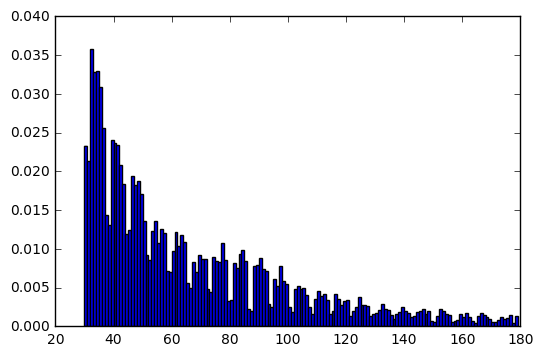

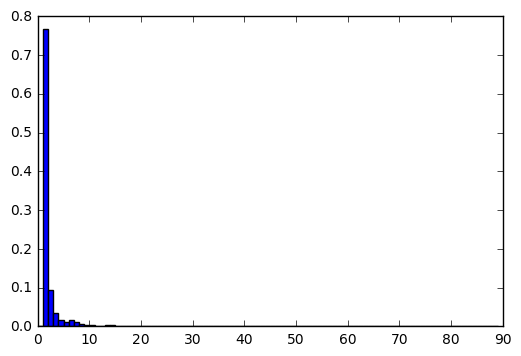

	 Saving json... Done!

***** DATE 14 of 30
***** WORKING ON DAY 2016-09-14
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


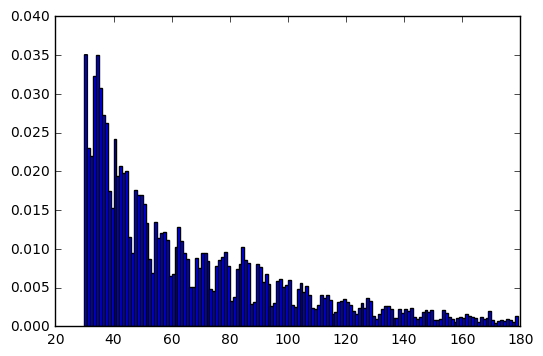

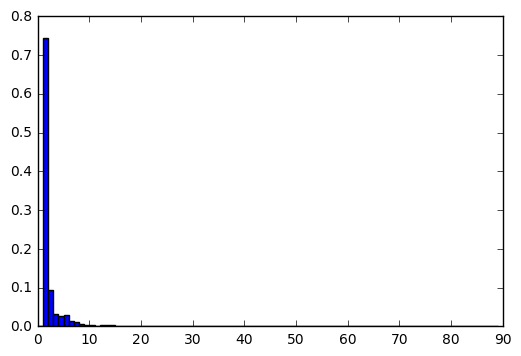

	 Saving json... Done!

***** DATE 15 of 30
***** WORKING ON DAY 2016-09-15
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


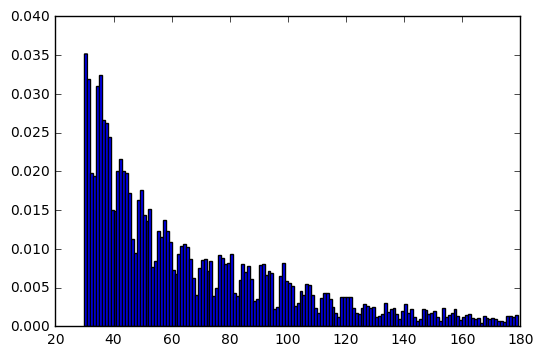

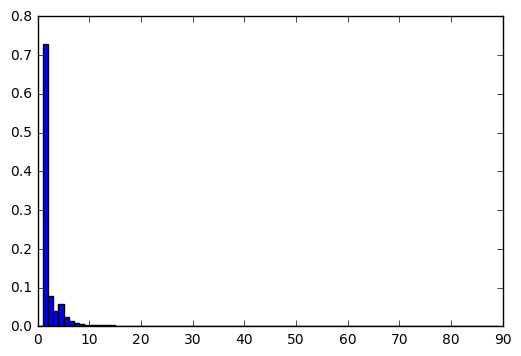

	 Saving json... Done!

***** DATE 16 of 30
***** WORKING ON DAY 2016-09-16
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


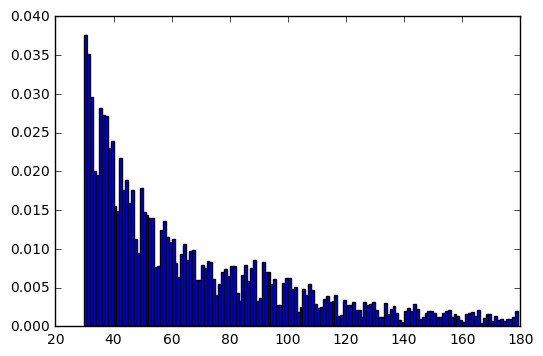

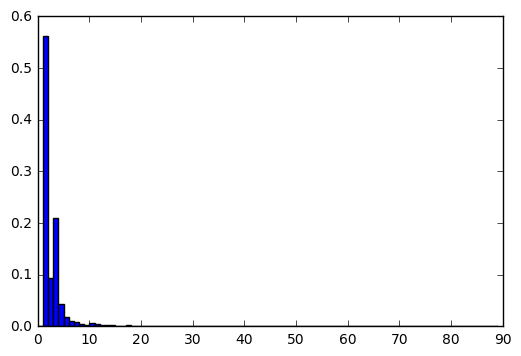

	 Saving json... Done!

***** DATE 17 of 30
***** WORKING ON DAY 2016-09-17
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


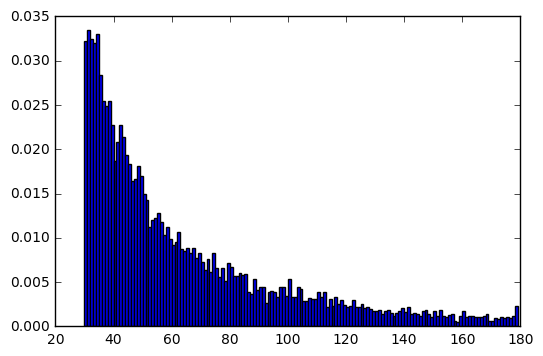

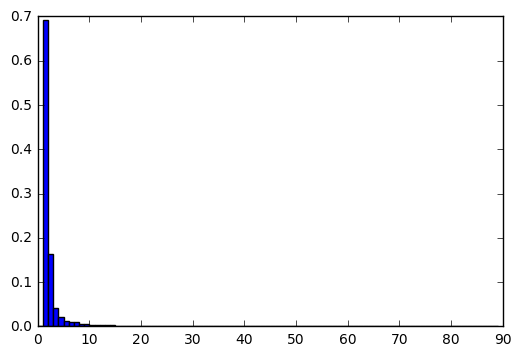

	 Saving json... Done!

***** DATE 18 of 30
***** WORKING ON DAY 2016-09-18
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


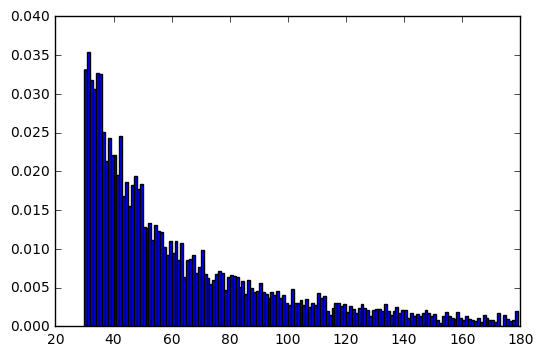

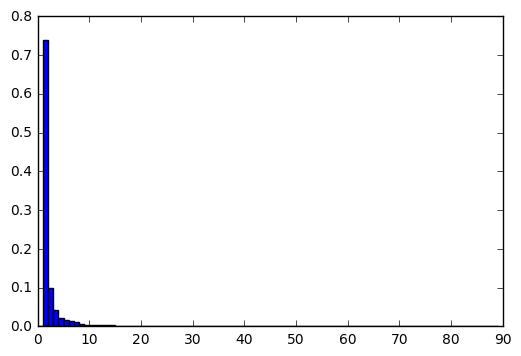

	 Saving json... Done!

***** DATE 19 of 30
***** WORKING ON DAY 2016-09-19
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


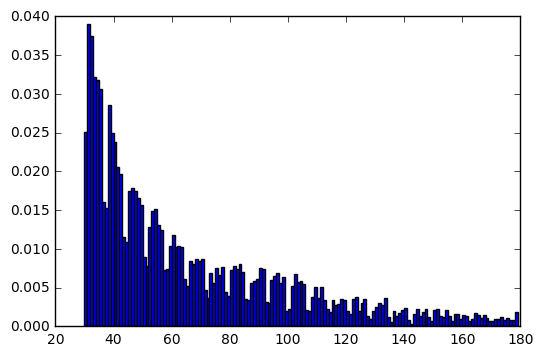

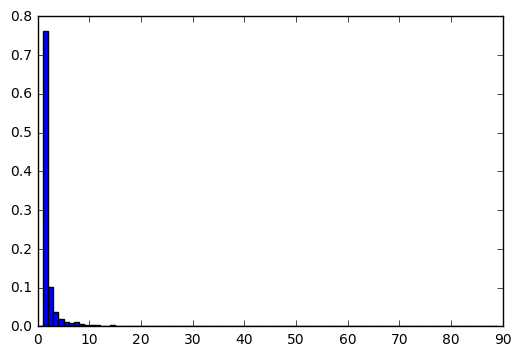

	 Saving json... Done!

***** DATE 20 of 30
***** WORKING ON DAY 2016-09-20
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


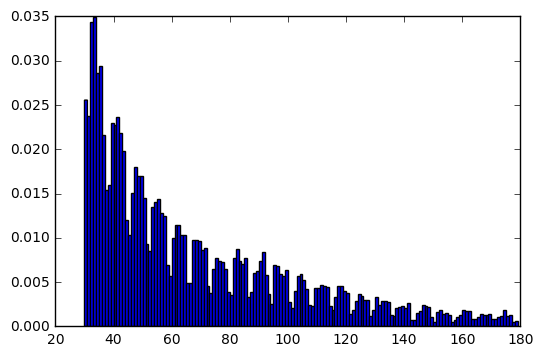

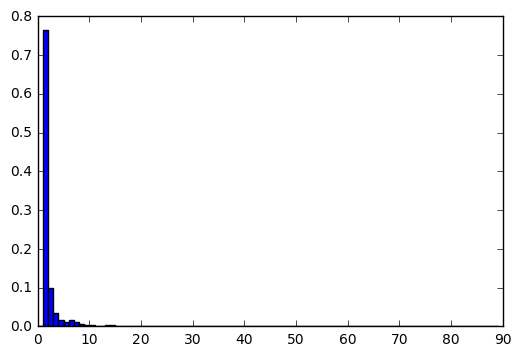

	 Saving json... Done!

***** DATE 21 of 30
***** WORKING ON DAY 2016-09-21
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


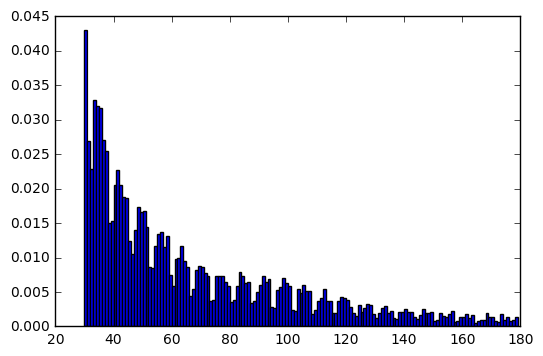

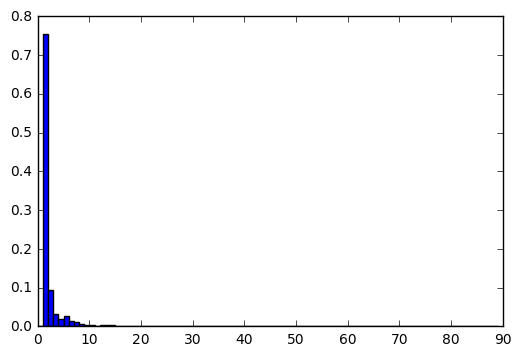

	 Saving json... Done!

***** DATE 22 of 30
***** WORKING ON DAY 2016-09-22
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


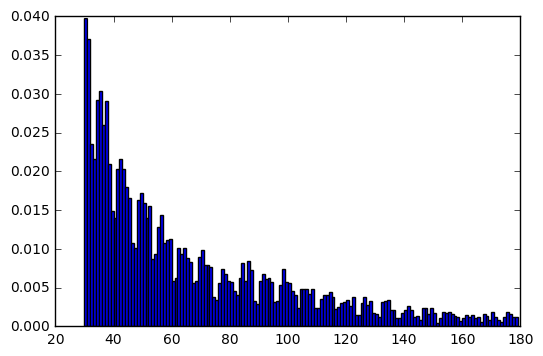

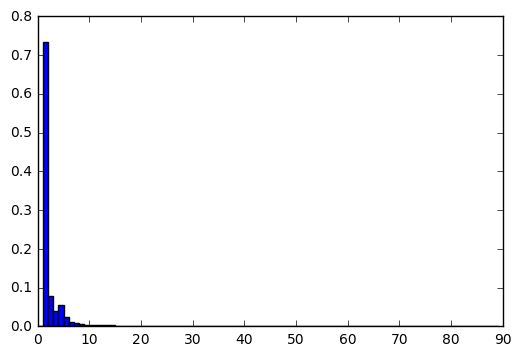

	 Saving json... Done!

***** DATE 23 of 30
***** WORKING ON DAY 2016-09-23
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


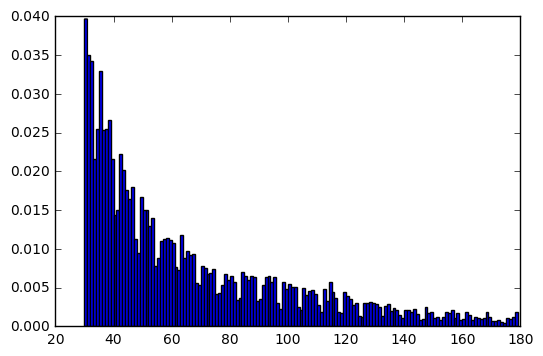

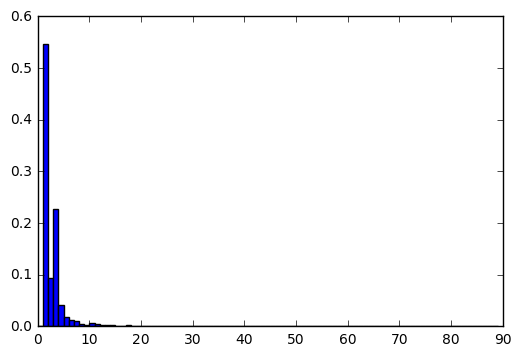

	 Saving json... Done!

***** DATE 24 of 30
***** WORKING ON DAY 2016-09-24
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


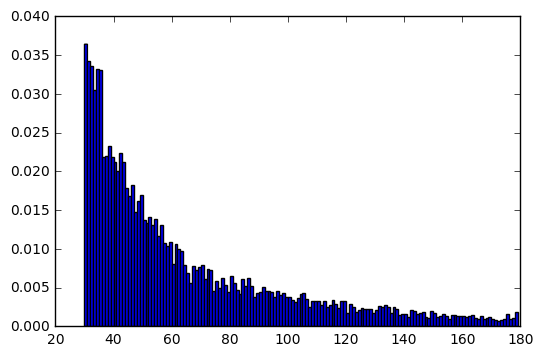

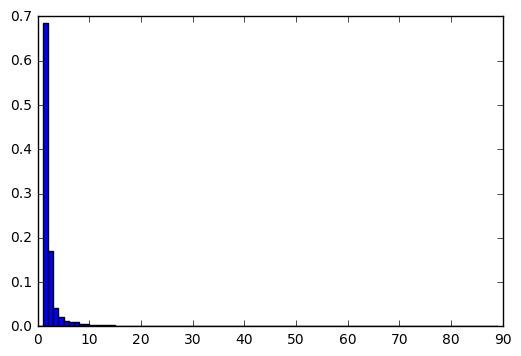

	 Saving json... Done!

***** DATE 25 of 30
***** WORKING ON DAY 2016-09-25
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


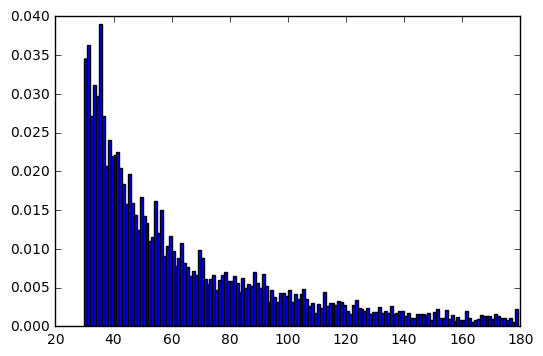

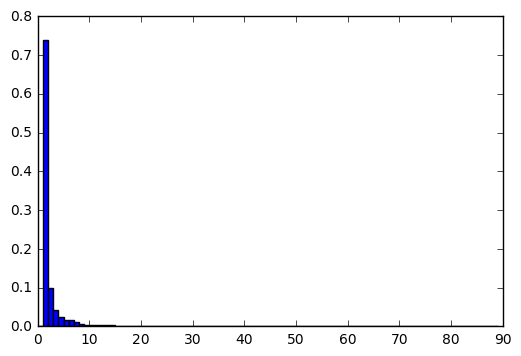

	 Saving json... Done!

***** DATE 26 of 30
***** WORKING ON DAY 2016-09-26
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


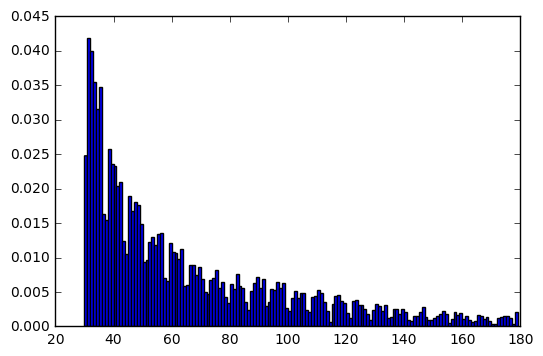

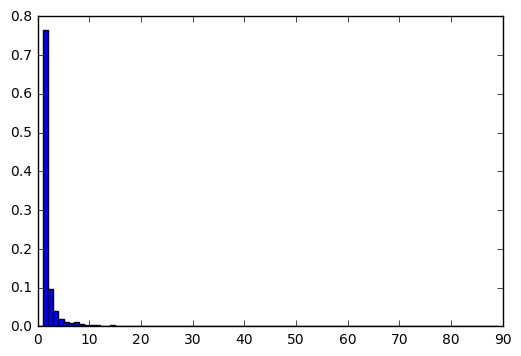

	 Saving json... Done!

***** DATE 27 of 30
***** WORKING ON DAY 2016-09-27
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


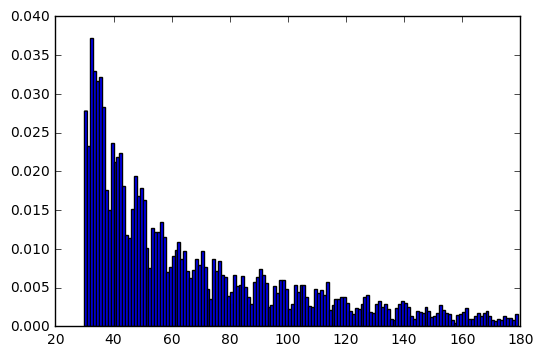

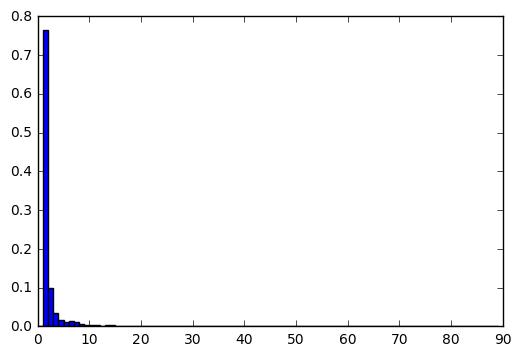

	 Saving json... Done!

***** DATE 28 of 30
***** WORKING ON DAY 2016-09-28
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


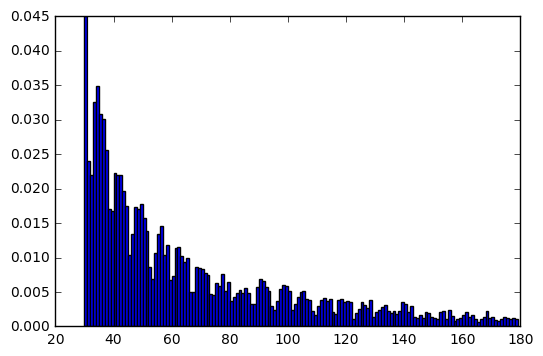

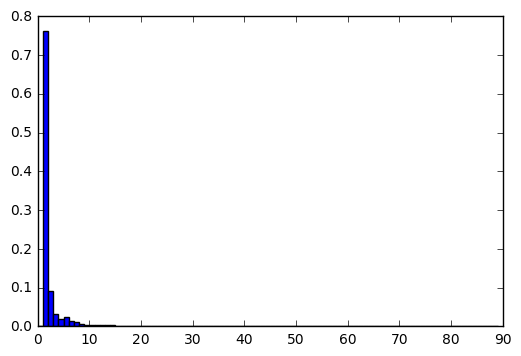

	 Saving json... Done!

***** DATE 29 of 30
***** WORKING ON DAY 2016-09-29
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


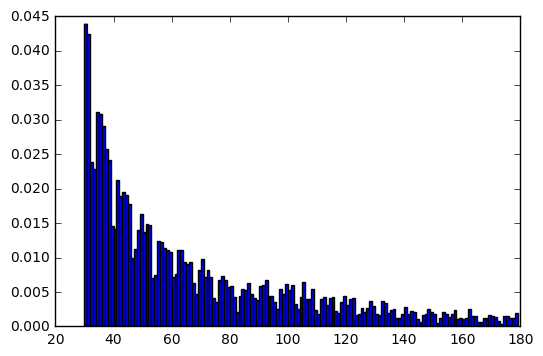

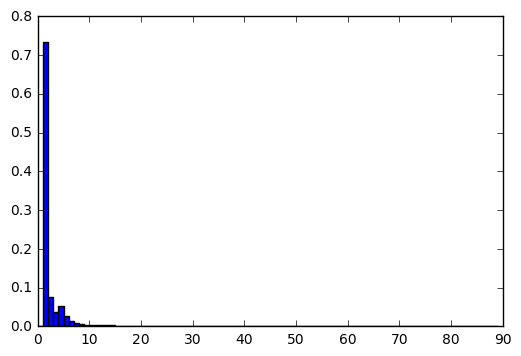

	 Saving json... Done!

***** DATE 30 of 30
***** WORKING ON DAY 2016-09-30
	 Aggregating data... Done!
	 Getting DAU... Done!
	 Making longitudinal... Done!
	 Mapping data... Done!
	 Getting counts...


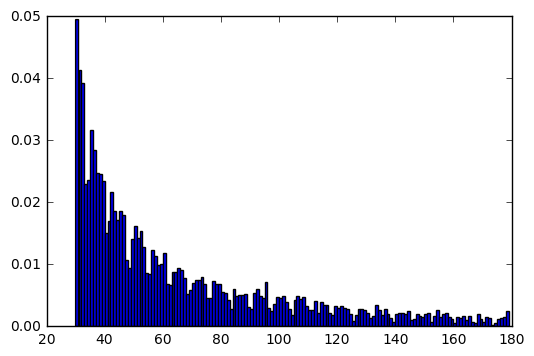

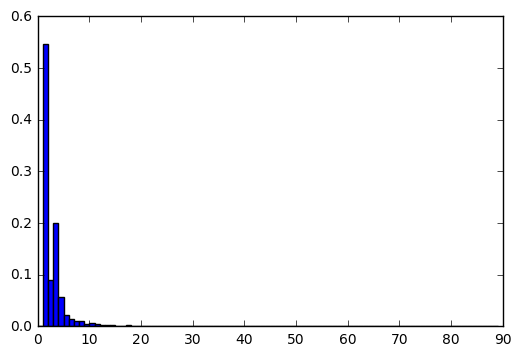

	 Saving json... Done!

***** MERGING SUMMARY JSON FILES... DONE!


In [6]:
main(date(2016,9,1), date(2016,9,30))